#### Module 1

**Marine Heatwaves**

In this Module we will learn how to use SST data to define and analyse Marine heatwaves (MHWs). We will learn how the selection of different sources and time periods of SST data impacts the definition, and therefore analysis, of MHWs. Specifically, we will:

* Learn the definition of MHWs following Hobday et al.
* Learn to reduce bias when looking at different sources and slices of SST data
* Understand the impact that different SST data has on the defintion of MHWs
* Understand how the choice of SST data impacts the stability of trends and climatology

#### Downloading Data

In [1]:
import xarray as xr
import os
import json
import datetime
import glob
from pydap.client import open_url
from pydap.cas.get_cookies import setup_session
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs 
import cartopy.feature as ccf   
import pandas as pd     
from scipy import stats    
from xmhw.xmhw import threshold, detect, add_doy

In [2]:
def read_credentials_file(authentication_url, credentials_file):
    with open(credentials_file) as json_file:
        credentials = json.load(json_file)
        username, password = credentials[authentication_url]
        return username, password

In [3]:
def copernicus_datastore(authentication_url, dataset, credentials_file):
    '''
    This function authenticates the CMEMS Data Store
    '''
    username, password = read_credentials_file(authentication_url, credentials_file)
    session = setup_session(uri = 'https://cmems-cas.cls.fr/cas/login', username = username,password = password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    data_store = xr.backends.PydapDataStore(open_url(f'{authentication_url}/thredds/dodsC/{dataset}', session = session))
    return data_store

In [4]:
# Create a download directory for our OLCI products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

# Data downloading options
download_cmems_data = False
cmems_credentials_file = os.path.join(os.path.expanduser("~"),'.cmems_opendap')

tags = ["MY", "NRT"]

# Multi-year reprocessing
authentication_url_my = 'https://my.cmems-du.eu'
dataset_my = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
format_my = 'CLIM_OSTIA_SST_'

# Near real-time
authentication_url_nrt = 'https://nrt.cmems-du.eu'
dataset_nrt = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'
format_nrt = 'OPER_OSTIA_SST_'

# L4 Time series ROI
TS_region = [10, 36, 15, 42] # W, S, E, N

# climatology
start_year = 1982
end_year = 2023

In [5]:
# Time series
if download_cmems_data:
    for authentication_url, dataset, tag in zip([authentication_url_my, authentication_url_nrt], [dataset_my, dataset_nrt], tags):
        data_store = copernicus_datastore(authentication_url, dataset, cmems_credentials_file)
        DS = xr.open_dataset(data_store)
        
        # we call the parameters and we plot the time series:
        for iter_year in range(start_year, end_year):
            try:
                dateStart = datetime.datetime(iter_year, 1, 1).strftime('%Y-%m-%d')
                dateEnd = (datetime.datetime(iter_year+1, 1, 1) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                print(f"Getting time series for {dataset}, {iter_year} to {iter_year+1}")
                TS = DS.analysed_sst.sel(lon=slice(TS_region[0], TS_region[2]), lat=slice(TS_region[1], TS_region[3]))\
                                    .sel(time=slice(f"{dateStart}", f"{dateEnd}"))\
                                    .mean(dim=["lon", "lat"])
                if iter_year == end_year or len(TS) >= 365:
                    TS.to_netcdf(os.path.join(download_dir,f"TS_{iter_year}_{tag}.nc"))
            except:
                print(f"No times available for {dataset}")
    
        DS.close()
        data_store.close()

Throughout this project, we'll build up a dictionary `heatwaves` which will keep track of all the data we generate. We'll start by creating sub-dictionaries `heatwaves["MY"]` and `heatwaves["NRT"]` and storing the MY and NRT data in the `"dataset"` attribute of each, respectively.

In [6]:
heatwaves = {}
for tag in tags:
    heatwaves[tag] = {}
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    DS = xr.open_mfdataset(TS_files)
    heatwaves[tag]["dataset"] = DS

#### Lesson 1

**Defining Marine Heatwaves**

Marine heatwaves are defined by having the properties:
* *Anomalously warm:* a recorded temperature above a high percentile threshold of given climatology data. 
    * Suggested percentile is 90%.
    * Avoids assumptions about the distribution of anomalies, unlike standard deviation.
    * Depends on the choice of climatology.
* *Prolonged:* the temperature must be above the threshold for a certain number of days to be considered as a heatwave.
    * Suggested duration is 5 days. This is backed up with evidence to balance heatwaves in tropical locations (elevated with shorter duration) and in cooler locations (disproportionately diminished with longer duration).
* *Discrete:* a period of cooler days must exist between two periods of elevated temperatures to distinguish them as different heatwaves.
    * Suggested period is 2 days.


#### Lesson 2

**Defining and exploring climatologies**

The `xmhw` Python package includes functionality to calculate climatology from a given SST dataset. Let's first look at our MY data. The `xmhw` package function `threshold` computes the climatology for a given time series `TS`, and stores it as the attribute `threshold(TS).seas`.

In [12]:
clim_start_year = start_year
clim_end_year = end_year

tag = "MY"

heatwaves[tag]["full"] = {}
working_dict = heatwaves[tag]["full"]

working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

Let's plot our first climatology, computed from the MY dataset over its full range (1982 - 2021).

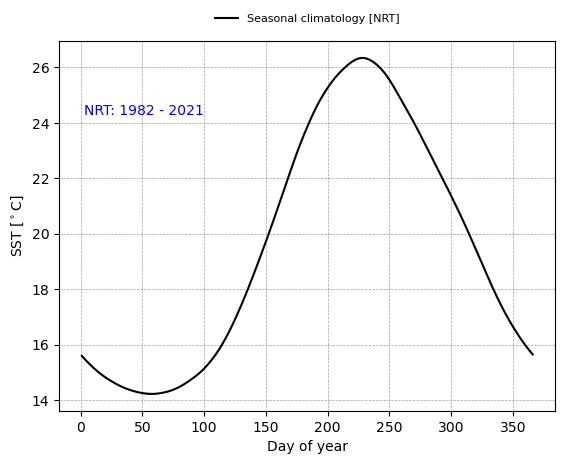

In [10]:
tag = "MY"

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k")
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

By changing the tag to `NRT` we can obtain the full climatology for NRT data. Over the next few lessons we will compare the NRT and MY climatologies generated from different time periods.

#### Lesson 3

**Comparing NRT and MY climatologies**

Let's start by plotting the climatologies produced from the full NRT and MY datasets.

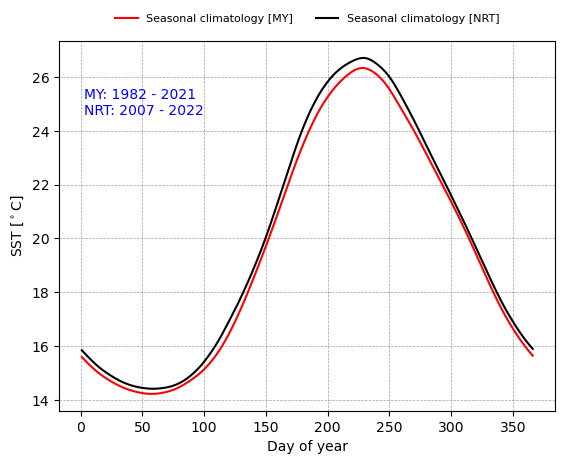

In [13]:
clim_start_year = start_year
clim_end_year = end_year
plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    working_dict = heatwaves[tag]["full"]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()



We see that NRT > MY. Can we draw any conclusions on this? No! We have made a biased comparison, because we are comparing climatologies generated from two different data sets **and** over two different time periods.

Instead, we should reduce bias by producing plots which differ in only one respect. In the next, we compare MY and NRT climatologies produced from a common period of data, in this case 2007-2021.

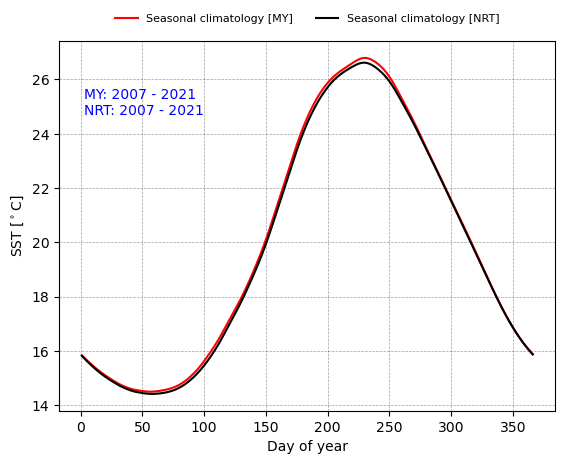

In [14]:
clim_start_year = 2007
clim_end_year = 2021
plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    heatwaves[tag]["common"] = {}
    working_dict = heatwaves[tag]["common"]
    working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
    working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
    working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
    working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

    clim = working_dict["xmhw_thresh"]
    p, = plt.plot(clim.doy, clim.seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

We see that over the course of the common period, the MY data reads slightly higher than the NRT data.

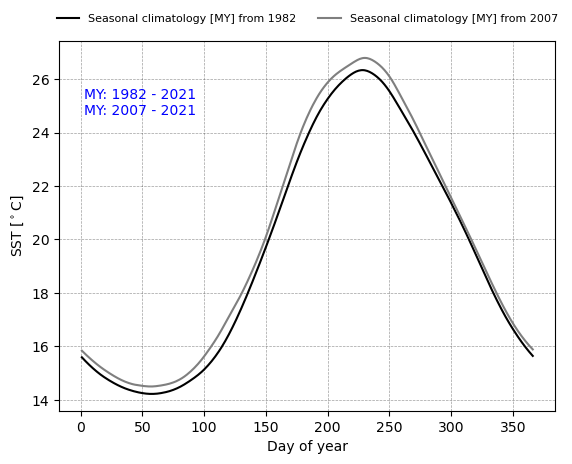

In [15]:
plots = []; labels = []; annot = ""
tag = "MY"

for series, plot_col in zip(["full", "common"], ["k", "tab:gray"]):
    working_dict = heatwaves[tag][series]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}] from {working_dict['start_year']}")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"   


plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

This suggests an upward trend in the MY data over time. We can confirm this with a time series regression.

Trend - R-squared (pvalue): 0.034494 K/year - 0.678777 (0.000000)


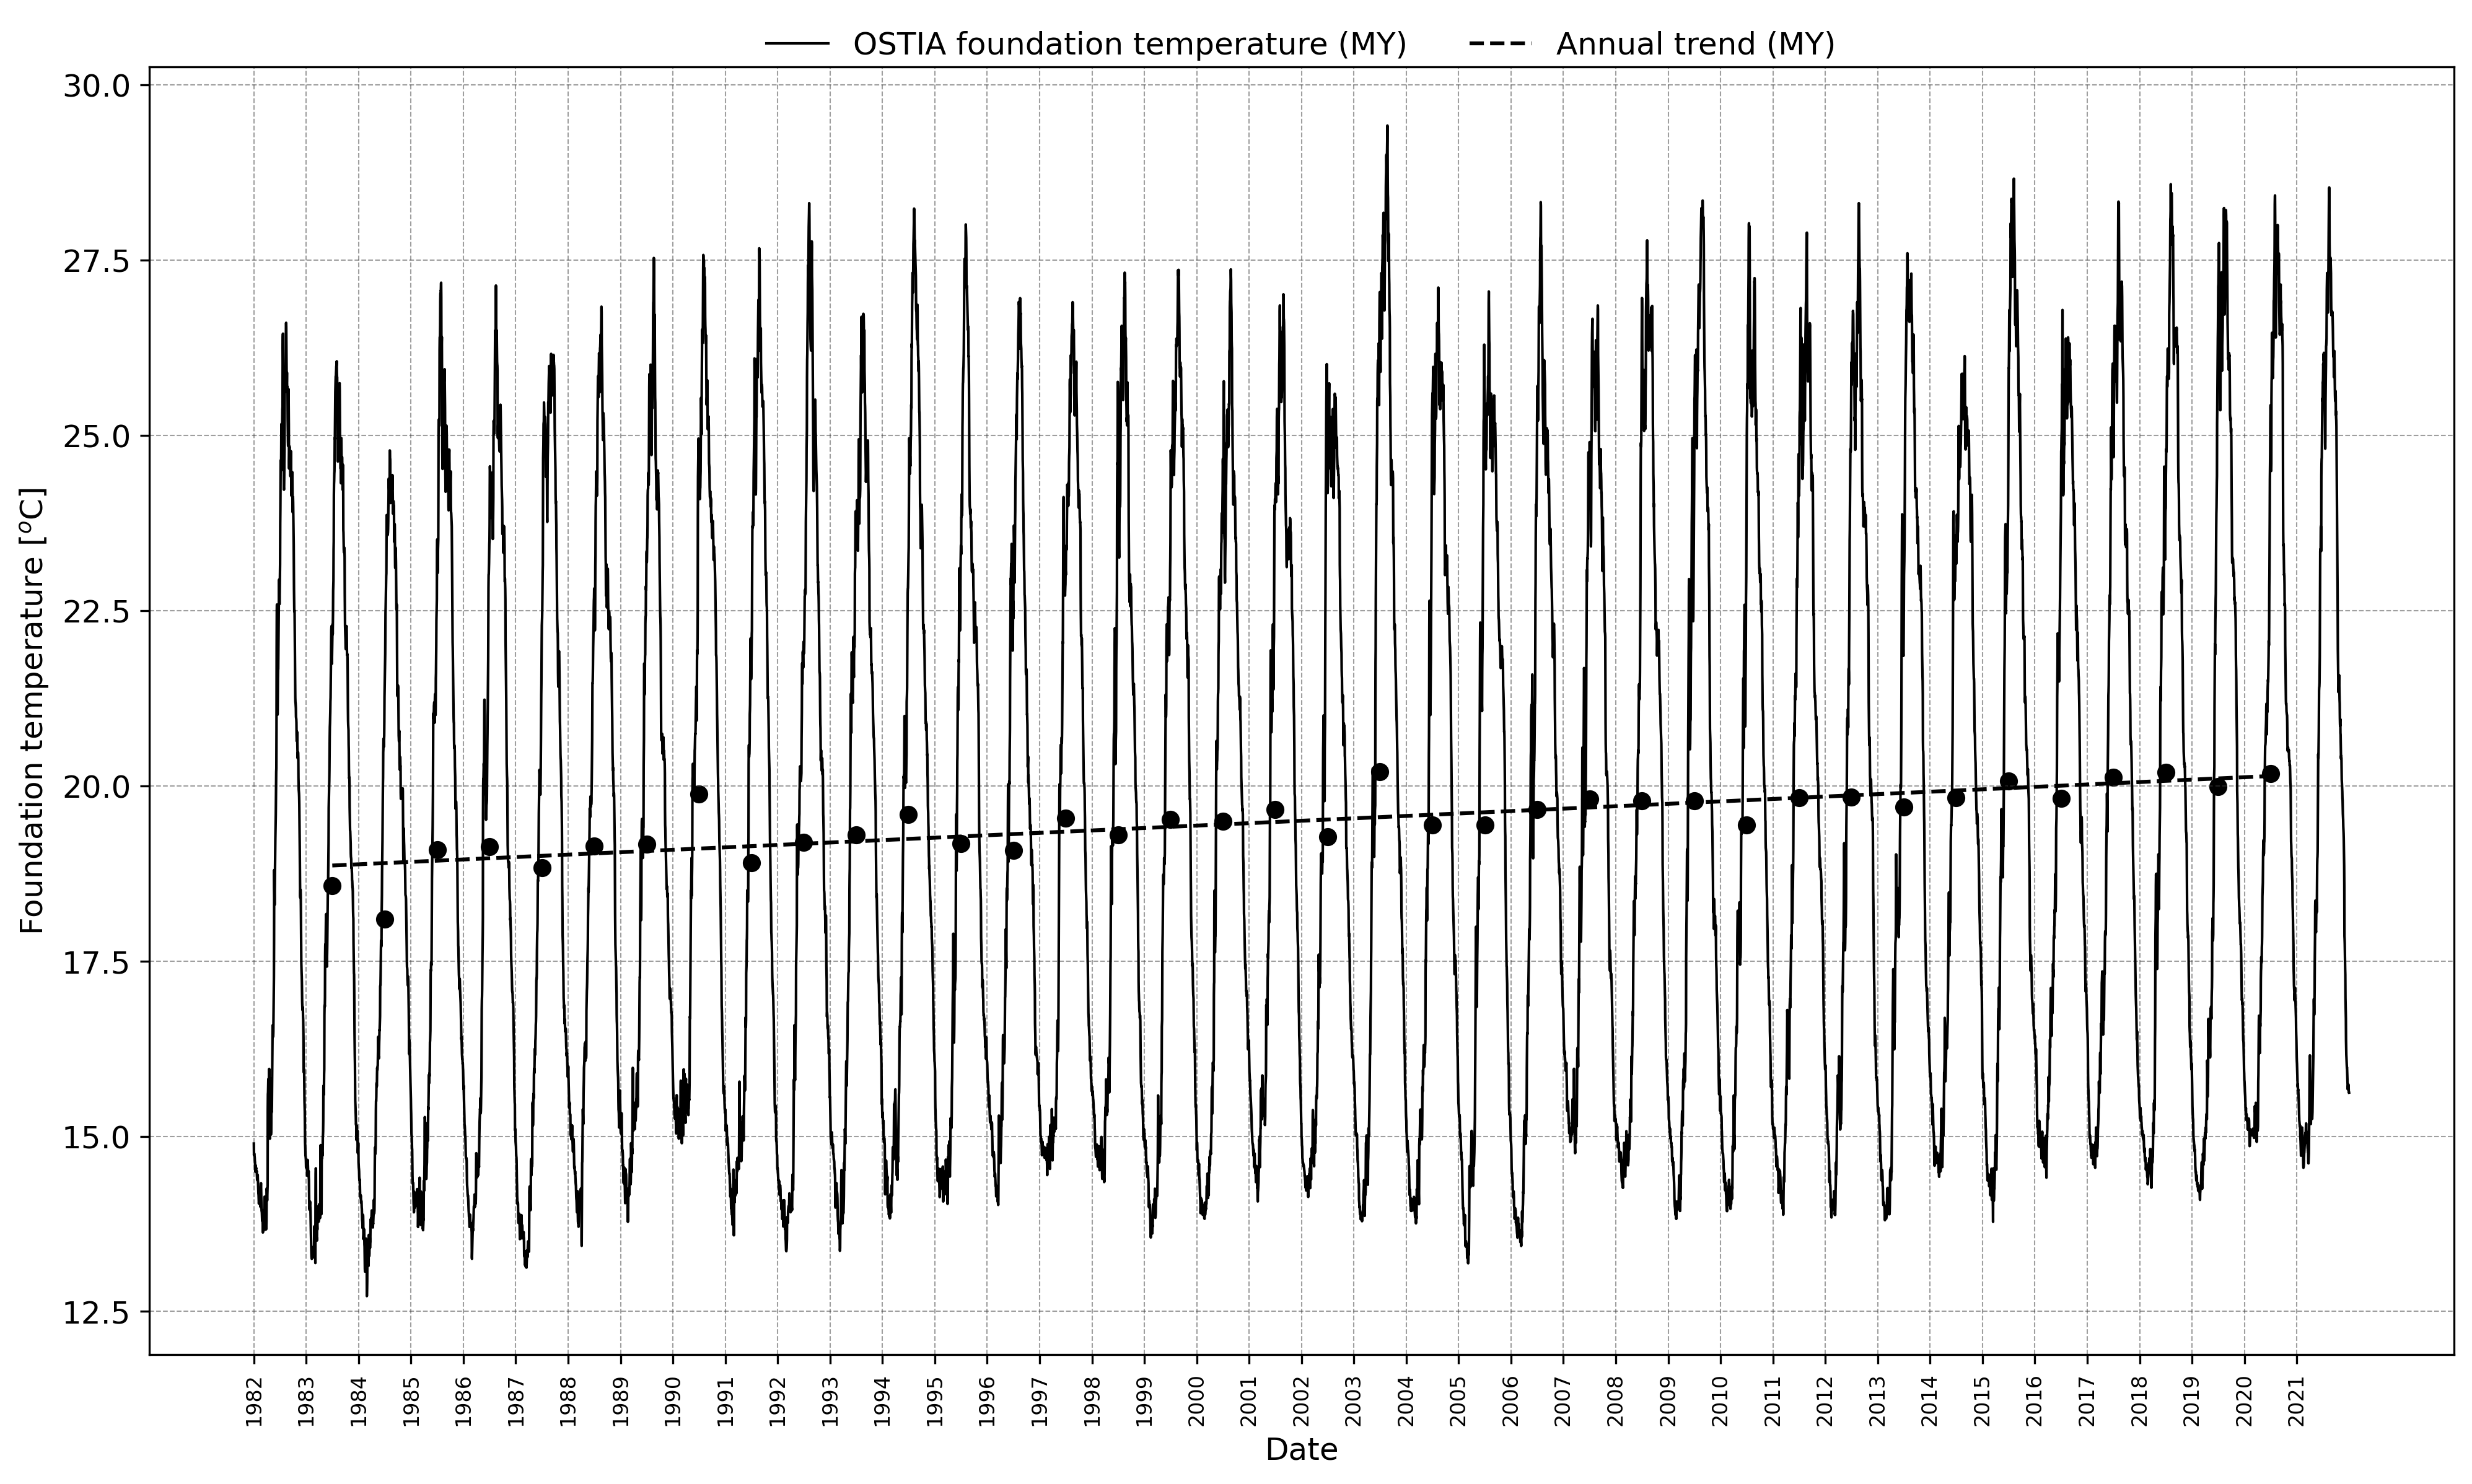

In [17]:
# setup figure
fig = plt.figure(figsize=(16, 9), dpi=300)
plt.rc('font', size=12)

plots = [] ; labels = []; xticks = []; xtick_labels= []

clim_start_year = start_year
clim_end_year = end_year

for tag, plot_colour in zip(["MY"], ["k"]):
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])

    p1, = plt.plot(DS.timeordinal, DS.analysed_sst - 273.15, linewidth=1, c=plot_colour)
    plots.append(p1)
    labels.append(f"OSTIA foundation temperature ({tag})")

    # calculate trend
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15)
    plt.scatter(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15, c=plot_colour)
    p2, = plt.plot(annual.timeordinal[1:-1], res.intercept + res.slope*annual.timeordinal[1:-1],
                   color=plot_colour, linestyle="--", label='fitted line')
    plots.append(p2)
    labels.append(f"Annual trend ({tag})")
    xticks.append([datetime.datetime(ii.data, 1, 1).toordinal() for ii in  annual.year])
    xtick_labels.append(annual.year)
    print(f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")

plt.xticks(np.array([item for sublist in xticks for item in sublist]),
           labels=np.array([item for sublist in xtick_labels for item in sublist]),
           rotation=90, fontsize=8)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
legend = plt.legend(plots, labels, frameon=False, bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=4)
plt.xlabel("Date")
plt.ylabel("Foundation temperature [$^{o}$C]")

plt.savefig("OSTIA_timeseries.png", bbox_inches='tight')

#### Lesson 3

**Detecting MHWs**

* Learn the process of plotting the MHW detection threshold for a given climatology.
* Learn to produce plots demonstrating the detection of MHWs.
* Appreciate how adjusting the detection threshold can change what MHWs are detected.

The function we used to produce our climatologies also produces a MHW detection threshold. Let's get a feel of these by plotting a few of them.

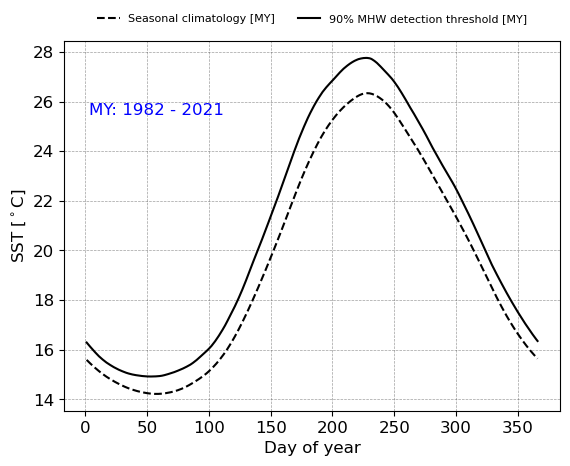

In [18]:
tag = "MY" #or "NRT"
series = "full" #or "common"

working_dict = heatwaves[tag][series]

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k", linestyle = '--')
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

q, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].thresh, c = "k")
plots.append(q)
labels.append(f"90% MHW detection threshold [{tag}]")

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

You can get a feel of the different thresholds by changing `tag` between `"MY"` and `"NRT"`, and `series` between `"full"` and `"common"`. Let's plot our climatology and threshold against the actual time series data. To do this, it will help to be able to more easily create slices of time series data, which the following function does. If `end_year` is left blank, it will produce a single year slice.

In [19]:
def create_TS_slice(tag, series_name, start_year, end_year = None):
    heatwaves[tag][series_name] = {}
    working_dict = heatwaves[tag][series_name]
    working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{start_year}-01-01', f'{end_year or start_year}-12-31')) - 273.15
    working_dict["start_year"] = start_year
    working_dict["end_year"] = end_year or start_year

Let's create a slice of the MY dataset over its most recent 5 years of recording, 2016-2021, and save it under the series name `"2016-2021"`. We'll then plot this slice against the full MY climatology and threshold.

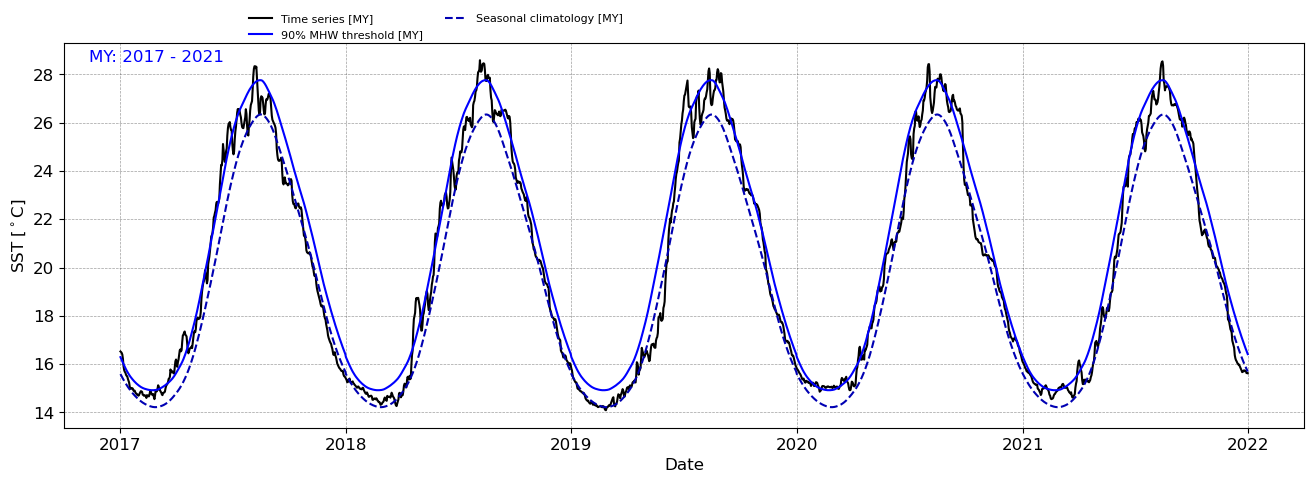

In [20]:
tag = "MY"
series_name = "2017-2021"

create_TS_slice(tag, series_name, 2017, 2021)

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag]["full"]

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = "k")
q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,1))
r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,0.7), linestyle = "--")
plots.append(p); plots.append(q); plots.append(r)
labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.3, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()


Looking at the plot, we see some clear candidates for heatwaves, the first being in early 2017. Additionally, there are spikes in each summer. It is not clear, however, whether these satisfy the *prolonged* part of the defintion of a MHW. Luckily, the `xmhw` package contains functionality to detect heatwaves. Let's see it in action for the above example.

In [21]:
tag = "MY"
series_name = "2017-2021"

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag]["full"]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

mhw_start_times = mhws.time_start.values.astype("datetime64[D]").tolist()
mhw_end_times = mhws.time_end.values.astype("datetime64[D]").tolist()
mhw_number = min(len(mhw_start_times), len(mhw_end_times))

for i in range(mhw_number):
    start = mhw_start_times[i]
    end = mhw_end_times[i]
    print(f"Heatwave {i+1} of {mhw_number}: \n start: {start.year}-{start.month}-{start.day}, end: {end.year}-{end.month}-{end.day}")

Heatwave 1 of 26: 
 start: 2017-3-19, end: 2017-4-19
Heatwave 2 of 26: 
 start: 2017-5-31, end: 2017-6-6
Heatwave 3 of 26: 
 start: 2017-6-11, end: 2017-6-30
Heatwave 4 of 26: 
 start: 2017-8-4, end: 2017-8-10
Heatwave 5 of 26: 
 start: 2018-4-20, end: 2018-5-1
Heatwave 6 of 26: 
 start: 2018-5-30, end: 2018-6-6
Heatwave 7 of 26: 
 start: 2018-8-2, end: 2018-8-22
Heatwave 8 of 26: 
 start: 2018-9-10, end: 2018-9-25
Heatwave 9 of 26: 
 start: 2019-6-25, end: 2019-7-13
Heatwave 10 of 26: 
 start: 2019-8-23, end: 2019-9-5
Heatwave 11 of 26: 
 start: 2019-9-16, end: 2019-9-22
Heatwave 12 of 26: 
 start: 2019-9-26, end: 2019-10-3
Heatwave 13 of 26: 
 start: 2019-10-25, end: 2019-11-6
Heatwave 14 of 26: 
 start: 2020-1-31, end: 2020-2-5
Heatwave 15 of 26: 
 start: 2020-2-10, end: 2020-3-6
Heatwave 16 of 26: 
 start: 2020-3-11, end: 2020-3-21
Heatwave 17 of 26: 
 start: 2020-4-9, end: 2020-4-13
Heatwave 18 of 26: 
 start: 2020-7-29, end: 2020-8-3
Heatwave 19 of 26: 
 start: 2020-8-19, end: 20

There were a total of 26 recorded heatwaves over the five year period we're looking at. Let's make this a bit easier to visuale. The following code will plot the periods in which heatwaves were identified.

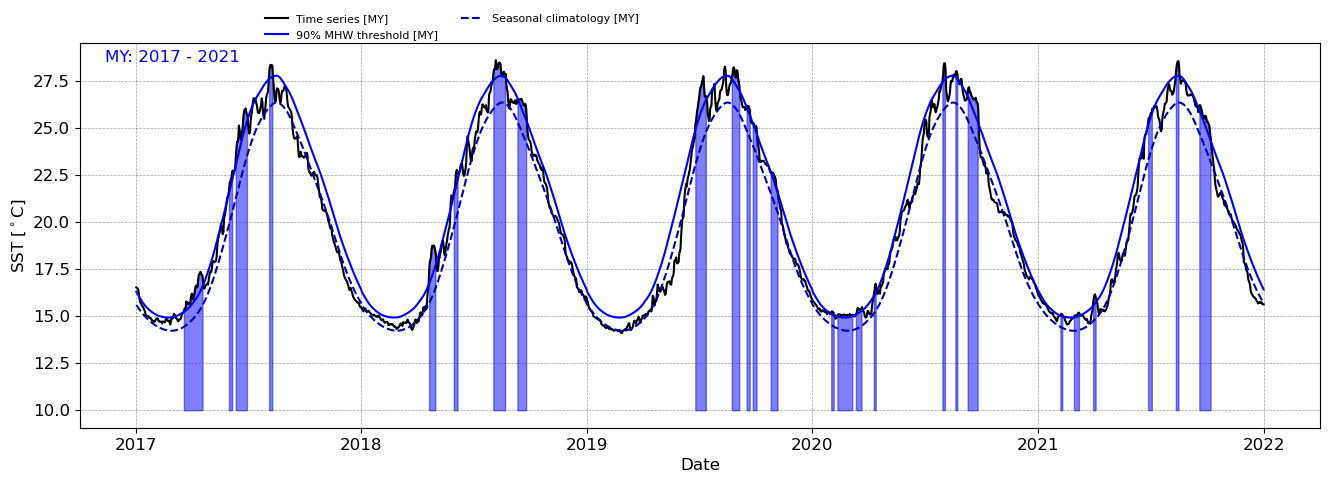

In [22]:
tag = "MY"
series = "2017-2021"

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

working_dict = heatwaves[tag][series]
clim_dict = heatwaves[tag]["full"]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
y_values = [working_dict["time_series"][int(t)] for t in t_values]

p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = "k")
q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,1))
r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,0.7), linestyle = "--")
plots.append(p); plots.append(q); plots.append(r)
labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

#plt.vlines(t_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)

for t1, t2 in zip(*[iter(t_values)]*2):
    plt.fill_between(working_dict["time_series"].time[int(t1):int(t2)], working_dict['time_series'][int(t1):int(t2)], 10, color = 'b', alpha = 0.5)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.3, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.02, 0.95), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()



In [23]:
tag = "NRT"
series = "2017-2021"

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

working_dict = heatwaves[tag][series]
clim_dict = heatwaves[tag]["full"]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
y_values = [working_dict["time_series"][int(t)] for t in t_values]

p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = "k")
q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,1))
r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = (0,0,0.7), linestyle = "--")
plots.append(p); plots.append(q); plots.append(r)
labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

#plt.vlines(t_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)

for t1, t2 in zip(*[iter(t_values)]*2):
    plt.fill_between(working_dict["time_series"].time[int(t1):int(t2)], working_dict['time_series'][int(t1):int(t2)], 10, color = 'b', alpha = 0.5)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

KeyError: '2017-2021'

<Figure size 1600x500 with 0 Axes>

That's better! Now we have the tools we need to get deeper into analysis.

#### Lesson 4

**Analysing MHWs for different data sources**

* Understand how different data sources detect different MHWs.
* Derive an example of a MHW which is detected from one dataset but not another.

Let's perform the same experiment as in Lesson 3 but with the NRT dataset over the same time period and compare the results. There are far fewer, only 9! Why would this be?

It looks like we should take a closer look at the data. For this, we will produce plots to compare MY and NRT heatwaves year-by-year. The following cell creates annual time-series slices for the common period 2007-2021 of the two datasets.

In [24]:
for year in range(2007, 2022):
    for tag in ["NRT", "MY"]:
        create_TS_slice(tag, f"{year}", year)

Next, for a given year, and for each of the MY and NRT datasets, we will plot the time series, the climatology and thresholds produced from 2007-2021. We will also graphically plot the detected heatwaves from each dataset. The plots may appear cluttered at first, but they provide deep insights. The following cell covers the year 2007.

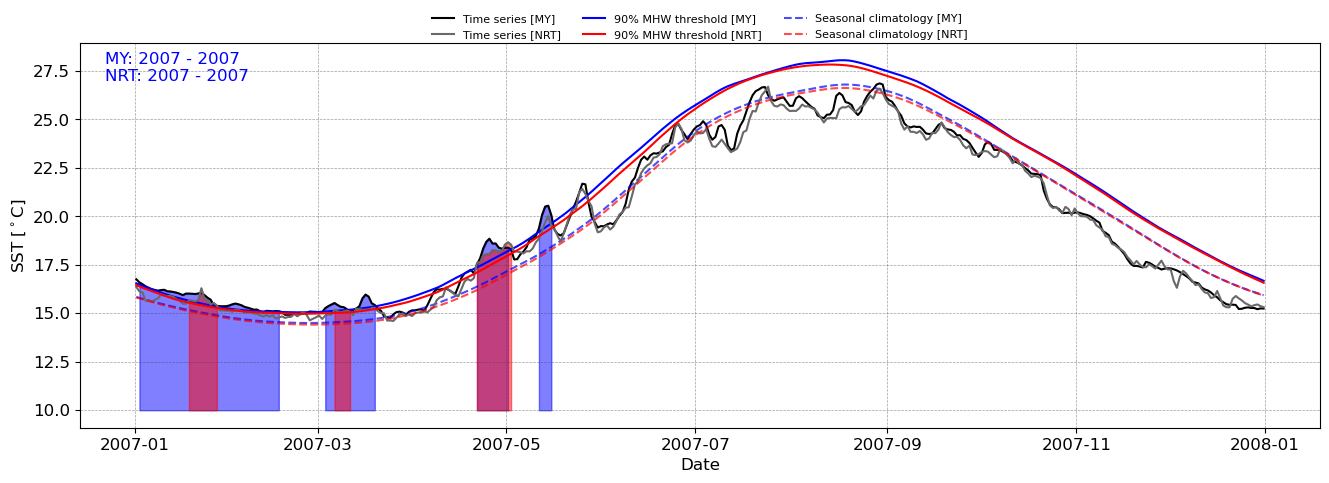

In [25]:
series = "2007"

plt.figure(figsize=(16, 5))
plots = []; labels = []; annot = ""

for tag, plot_col, plot_col2 in zip(["MY", "NRT"], ["b", "r"], ["k", "dimgrey"]):
    working_dict = heatwaves[tag][series]
    clim_dict = heatwaves[tag]["common"]
    
    mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

    t_values = np.union1d(mhws.index_start.values, mhws.index_end.values)
    y_values = [working_dict["time_series"][int(t)] for t in t_values]

    p, = plt.plot(working_dict["time_series"].time, working_dict["time_series"], c = plot_col2)
    q, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].thresh[working_dict["time_series"].time.dt.dayofyear-1], c = plot_col)
    r, = plt.plot(working_dict["time_series"].time, clim_dict['xmhw_thresh'].seas[working_dict["time_series"].time.dt.dayofyear-1], c = plot_col, alpha = 0.7, linestyle = "--")
    plots.append(p); plots.append(q); plots.append(r)
    labels.append(f"Time series [{tag}]"); labels.append(f"90% MHW threshold [{tag}]"); labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

    #plt.vlines(t_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)

    for t1, t2 in zip(*[iter(t_values)]*2):
        plt.fill_between(working_dict["time_series"].time[int(t1):int(t2)+1], working_dict['time_series'][int(t1):int(t2)+1], 10, color = plot_col, alpha = 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend([plots[i] for i in [0,3,1,4,2,5]], [labels[i] for i in [0,3,1,4,2,5]],
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=3, fontsize=8)
plt.annotate(annot, (0.02, 0.9), xycoords="axes fraction", color='b')
plt.xlabel(r'Date')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

We immediately find an example of a heatwave that is detected from the MY data but not the NRT data, occuring around mid-May. 

**Exerise**
By changing the `series` parameter in the previous cell, find:
* an example of the opposite, that is find a year for which the NRT data detects a heatwave, but the MY data does not; (2012, 2016)
* an example of a year in which both of these happen; (2020)
* an example of a year where within the period of a heatwave detected by one dataset, at least two are detected by the other dataset; (2014, 2017)
* an example of a year in which the same number of heatwaves occur at roughly the same times; (2009, 2018, 2019, 2021)
* an example of a year in which the same number of heatwaves occur, but the times are different. (2020)

If nothing else, this example demonstrates that even when looking at climatologies and time series over the same period, with the same definition of marine heatwaves, there is a lot of variation in what we can detect when comparing two datasets.

#### Lesson 5

**Analysing MHWs for different climatologies produced from the same data source**

* Appreciate that different climatologies produced from the same data source (different time periods) affects the detection of MHWs.
* Appreciate the relationship between using longer climatologies and seeing more heatwaves as time progresses (density?).
* Derive an example of a year where the MHWs detected are different based on using current climatology vs. climatology up to that year.

Let's suppose that we've chosen the data source that we want to work with to analyse MHWs. As you may have started to realise in Lesson 3, the detection of heatwaves is still very sensitive to the period of data used to define climatology. To demonstrate this, the following cell calculates all the MHWs detected by the MY data, using climatology based on its full range (1982 - 2021), and plots their density.

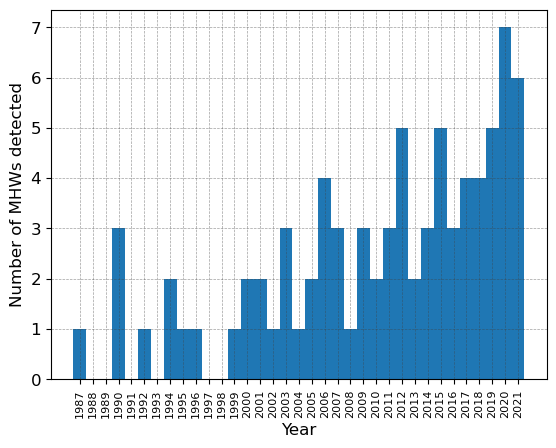

In [26]:
tag = "MY"
series_name = "full"
clim_series_name = "full"

working_dict = heatwaves[tag][series_name]
clim_dict = heatwaves[tag][clim_series_name]

mhws = detect(working_dict["time_series"], clim_dict["xmhw_thresh"].thresh, clim_dict["xmhw_thresh"].seas)

mhw_start_times = mhws.time_start.values.astype("datetime64[D]").tolist()

data = [t.year for t in mhw_start_times]
plt.hist(data, bins = np.arange(min(data),max(data)+2) - 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(range(min(data),max(data)+1), rotation = 90, fontsize = 8)
plt.xlabel(r'Year')
plt.ylabel(r'Number of MHWs detected')
plt.show()

It would be easy to conclude that the incidence of MHWs has increased over the years, but this plot does not capture the full story because we've already seen in previous lessons that MY data has an upwards trend. Since the detection threshold is the same whether we're looking at heatwaves in 1982 or 2021, we'd expect more heatwave detections when sea temperatures are, on average, higher. Therefore the above density plot may be telling us nothing new.

Change the parameter `clim_series_name` in the above cell to `"common"`. This will detect heatwaves in the period 1982-2021 based off of climatology calculated in the period 2007 - 2021. While we again see relatively more heatwaves detected in the second half of the plot, the behaviour is much 'flatter'. Moreover, there are spikes of heatwaves in 2003, 2006 and 2007 which were not as clear the `"full"` plot.

The above two simple plots demonstrate that it is difficult to track the incidence of heatwaves over time, and we must be very careful not to bias our conclusions. In the following exercise, we will generate tools to track the incidence of heatwaves for a given year using all the available information up to that year, *but not beyond*. For example, to detect heatwaves in 2007, we will use a climatology generated from the years 1982 up to 2007. As you're working through, note down any issues you think of that might bias comparisons between different years.

To ensure we're using enough data, we begin the experiment in the year 1996, giving us 15 years of data from 1982.

In [27]:
tag = "MY"

for year in range(1996, 2022):
    series_name = f"up to {year}"
    create_TS_slice(tag, series_name, 1982, year)
    create_TS_slice(tag, f"{year}", year)
    working_dict = heatwaves[tag][series_name]
    working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])
    working_dict["xmhw_detect"] = detect(heatwaves[tag][f"{year}"]["time_series"],working_dict["xmhw_thresh"].thresh, working_dict["xmhw_thresh"].seas)


Let's plot our new experiment on a similar histogram.

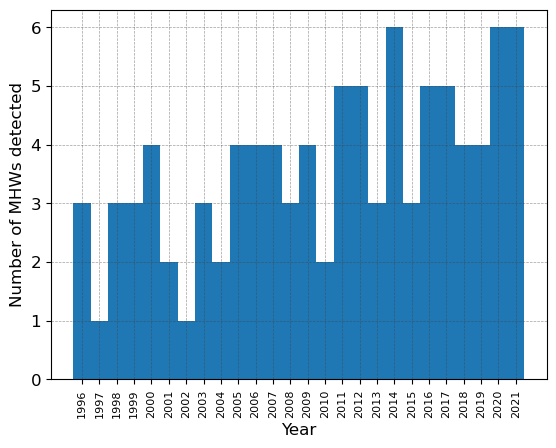

In [28]:
data = []
for year in range(1996,2022):
    series_name = f"up to {year}"
    for i in range(len(heatwaves[tag][series_name]["xmhw_detect"]["time_start"].values)):
        data.append(year)

plt.hist(data, bins = np.arange(min(data),max(data)+2) - 0.5)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xticks(range(min(data),max(data)+1), rotation = 90, fontsize = 8)
plt.xlabel(r'Year')
plt.ylabel(r'Number of MHWs detected')
plt.show()

We do still see an upward trend in the data. What conclusions can we draw?

#### Lesson 6

**Stability**

Work in progress: calculation of successive 15 year trend gradients of MY data.

1982 -- 1997: Trend - R-squared (pvalue): 0.056956 K/year - 0.321520 (0.001188)
1983 -- 1998: Trend - R-squared (pvalue): 0.053401 K/year - 0.297050 (0.001923)
1984 -- 1999: Trend - R-squared (pvalue): 0.022796 K/year - 0.119315 (0.051268)
1985 -- 2000: Trend - R-squared (pvalue): 0.025940 K/year - 0.147835 (0.030505)
1986 -- 2001: Trend - R-squared (pvalue): 0.027988 K/year - 0.168196 (0.021104)
1987 -- 2002: Trend - R-squared (pvalue): 0.023288 K/year - 0.132301 (0.040443)
1988 -- 2003: Trend - R-squared (pvalue): 0.013967 K/year - 0.049745 (0.196613)
1989 -- 2004: Trend - R-squared (pvalue): 0.031500 K/year - 0.152426 (0.028072)
1990 -- 2005: Trend - R-squared (pvalue): 0.046200 K/year - 0.382649 (0.000337)
1991 -- 2006: Trend - R-squared (pvalue): 0.030690 K/year - 0.214314 (0.009124)
1992 -- 2007: Trend - R-squared (pvalue): 0.028612 K/year - 0.192406 (0.013608)
1993 -- 2008: Trend - R-squared (pvalue): 0.032188 K/year - 0.229400 (0.006913)
1994 -- 2009: Trend - R-squared (pvalue)

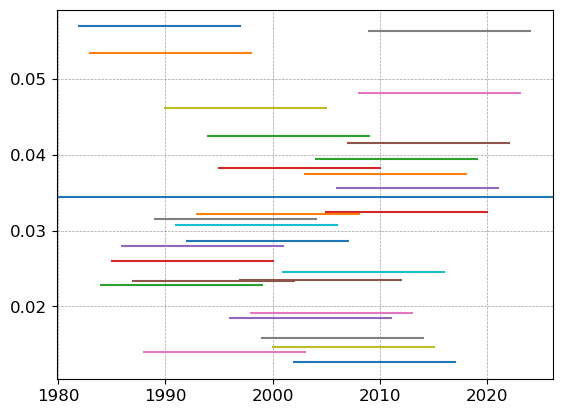

In [29]:
tag = "MY"
gap = 15
TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
for clim_start_year in range(1982, 2010):
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_start_year + gap}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15)
    print(f"{clim_start_year} -- {clim_start_year + gap}:", f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")
    plt.plot([clim_start_year, clim_start_year + gap], [res.slope*365, res.slope*365])
    
plt.axhline(0.034494)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()



### Materials in progress

These will fill parts of the course above.

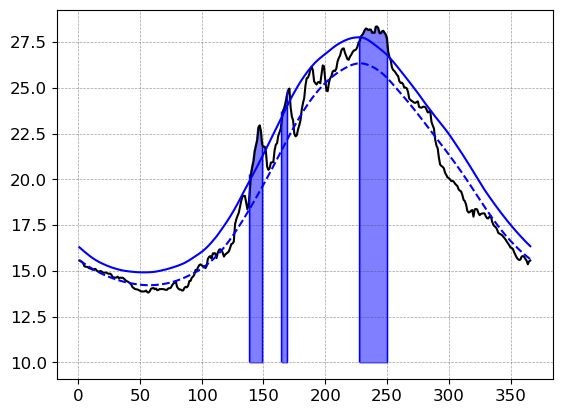

In [31]:
tag = "MY"

working_dict = heatwaves[tag]["full"]

year = 2009

working_dict[f'{year}'] = {}
working_dict[f'{year}']['time_series'] = working_dict["time_series"].sel(time = slice(f'{year}-01-01', f'{year}-12-31'))
working_dict[f'{year}']['mhws'] = detect(working_dict[f'{year}']["time_series"], working_dict["xmhw_thresh"].thresh, working_dict["xmhw_thresh"].seas)
#np.where(working_dict['2003']['time_series'].time == working_dict['2003']['mhws'].time_start[2].values)
x_values = np.union1d(working_dict[f'{year}']['mhws'].index_start.values, working_dict[f'{year}']['mhws'].index_end.values)

y_values = [working_dict[f'{year}']['time_series'][int(x)] for x in x_values]


plt.plot(working_dict[f'{year}']['time_series'].doy, working_dict[f'{year}']['time_series'], c = "k")
plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].thresh, c = "b")
plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = "b", linestyle = "--")
#plt.scatter(x_values, y_values, s = 10, c = "r", zorder = 2)
plt.vlines(x_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)
for t1, t2 in zip(*[iter(x_values)]*2):
    plt.fill_between(working_dict['xmhw_thresh'].doy[int(t1):int(t2)], working_dict[f'{year}']['time_series'][int(t1):int(t2)], 10, color = 'b', alpha = 0.5)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()